In [ ]:
import torch
import matplotlib.pyplot as plt
from einops import rearrange

In [ ]:
# from bliss.datasets.io import load_dataset_npz
# images = load_dataset_npz("../../data/datasets/test_ds_23.npz")['images']
# images.shape

In [ ]:
ds = torch.load("../../data/cache/sampling_test1.pt")

In [ ]:
ds.keys()

dict_keys(['samples', 'truth', 'snr', 'bld', 'n_source_probs', 'locs_mean', 'locs_sd'])

In [ ]:
_bld = ds['bld'][:, 0]
_bld.shape

torch.Size([6258])

In [ ]:
_snr = ds['snr'][:, 0]
_snr.shape

torch.Size([6258])

(array([  1.,   2.,   0.,   2.,   2.,   1.,   1.,   3.,   4.,   7.,   3.,
          8.,   6.,  16.,  15.,  22.,  39.,  35.,  70.,  80., 134., 258.,
        456., 780., 809., 689., 537., 459., 350., 276., 228., 183., 141.,
         95.,  67.,  59.,  43.,  26.,  26.,  22.,   7.,   5.,   6.,   4.,
          3.,   1.,   2.,   1.,   0.,   0.,   1.]),
 array([-2.51024604, -2.37974787, -2.24924994, -2.11875176, -1.98825371,
        -1.85775554, -1.72725749, -1.59675932, -1.46626127, -1.33576322,
        -1.20526505, -1.07476699, -0.94426888, -0.81377077, -0.68327272,
        -0.55277461, -0.4222765 , -0.29177842, -0.1612803 , -0.03078221,
         0.09971588,  0.23021398,  0.36071208,  0.49121016,  0.62170827,
         0.75220639,  0.88270444,  1.01320255,  1.1437006 ,  1.27419877,
         1.40469682,  1.53519499,  1.66569304,  1.7961911 ,  1.92668927,
         2.05718732,  2.18768549,  2.31818342,  2.44868159,  2.57917976,
         2.7096777 ,  2.84017587,  2.97067404,  3.10117221,  3.23167

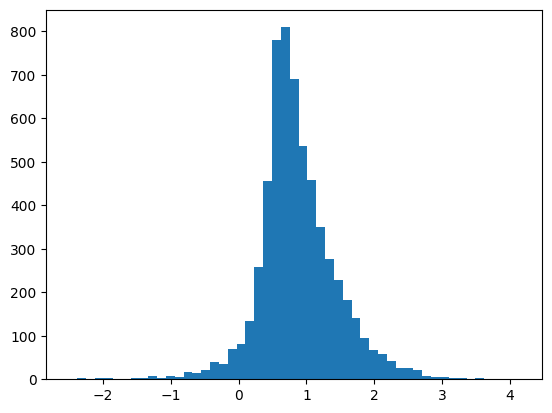

In [ ]:
mask = _snr > 0 
plt.hist(_snr[mask].log10(), bins=51)

In [ ]:
_fluxes = ds['samples']['flux']
_fluxes.shape

torch.Size([10, 6258, 1])

In [ ]:
_fluxes[:, 251, 0] # seems pretty consistent across catalogs

tensor([19989.0801, 20384.5000, 21439.6133, 21243.4258, 20578.1895, 20718.6074,
        21537.3613, 20373.8750, 20344.8301, 21994.3164])

In [ ]:
ds['truth']['flux'][251, 0]

tensor(19422.3926)

In [ ]:
sum(ds['truth']['galaxy_bools'])

tensor([5711.])

In [ ]:
_snr[241]

tensor(34.5696)

In [ ]:
_bld[241]

tensor(0.0032)

(array([2687.,  790.,  409.,  325.,  248.,  190.,  183.,  146.,  129.,
         135.,   96.,   71.,   80.,   89.,   82.,   70.,   57.,   67.,
          58.,   64.,   68.,   59.,   55.,   54.,   46.]),
 array([0.        , 0.03974803, 0.07949606, 0.1192441 , 0.15899213,
        0.19874015, 0.2384882 , 0.27823621, 0.31798425, 0.3577323 ,
        0.39748031, 0.43722835, 0.47697639, 0.51672441, 0.55647242,
        0.59622049, 0.63596851, 0.67571652, 0.71546459, 0.7552126 ,
        0.79496062, 0.83470869, 0.8744567 , 0.91420472, 0.95395279,
        0.9937008 ]),
 <BarContainer object of 25 artists>)

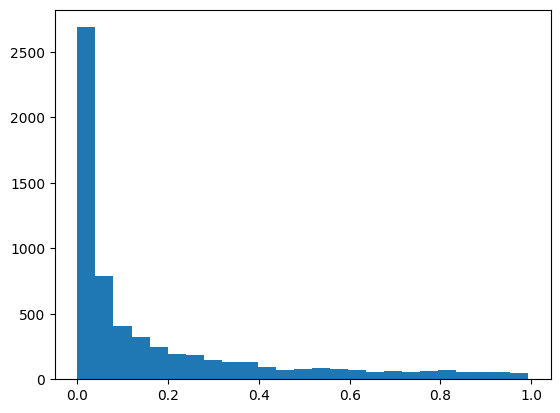

In [ ]:
plt.hist(_bld, bins=25)

## flux residuals

In [ ]:
sum(ds['truth']['galaxy_bools'][: ,0].bool())

tensor(5711)

In [ ]:
ds['samples']['flux'].shape

torch.Size([10, 6258, 1])

In [ ]:
mask = (ds['snr'][:, 0] > 0) & (ds['truth']['galaxy_bools'][:, 0].bool())

tflux = ds['truth']['flux'][mask, 0]
sfluxes = ds['samples']['flux'][:, mask, 0]
tflux.shape, sfluxes.shape
snr = ds['snr'][mask, 0]
bld = ds['bld'][mask, 0]

snr.shape, sfluxes.shape, tflux.shape, bld.shape

(torch.Size([5702]),
 torch.Size([10, 5702]),
 torch.Size([5702]),
 torch.Size([5702]))

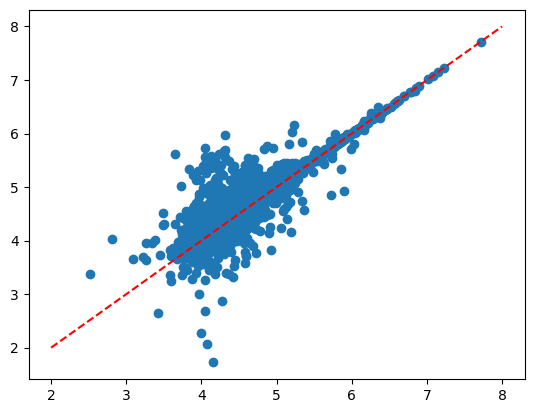

In [ ]:
# just look at scatter of mean  as a first pass
plt.scatter(tflux.log10(), sfluxes.nanquantile(q=0.5,axis=0).log10())
plt.plot([2, 8], [2, 8], 'r--')

In [ ]:

# bins
snr_mask = (snr > 3) * (snr <= 1000)
_snr = snr[snr_mask]
_snr_log = torch.log10(_snr)
qs = torch.linspace(0, 1, 10)
snr_bins = torch.quantile(_snr_log, qs)
snr_middle = (snr_bins[1:] + snr_bins[:-1]) / 2


In [ ]:
f1 = rearrange(tflux, 'n -> 1 n')
res = (sfluxes - f1) / f1
_res = res[:, snr_mask]
_res.shape, res.shape

(torch.Size([10, 4863]), torch.Size([10, 5702]))

In [ ]:
# defaults correspond to 1 sigma in Gaussian distribution
def _calculate_statistics(sy, x, x_bins, qs=(0.159, 0.841)):
    medians, q1s, q3s = [], [], []
    for ii in range(len(x_bins) - 1):
        _mask = (x > x_bins[ii]) * (x < x_bins[ii + 1])
        masked_sy = sy[:, _mask]
        medians.append(torch.nanmedian(masked_sy.ravel()))
        q1s.append(torch.nanquantile(masked_sy.ravel(), qs[0]))
        q3s.append(torch.nanquantile(masked_sy.ravel(), qs[1]))
    return torch.tensor(medians), torch.tensor(q1s), torch.tensor(q3s)

In [ ]:
m, q1, q2 = _calculate_statistics(_res, _snr_log, snr_bins)

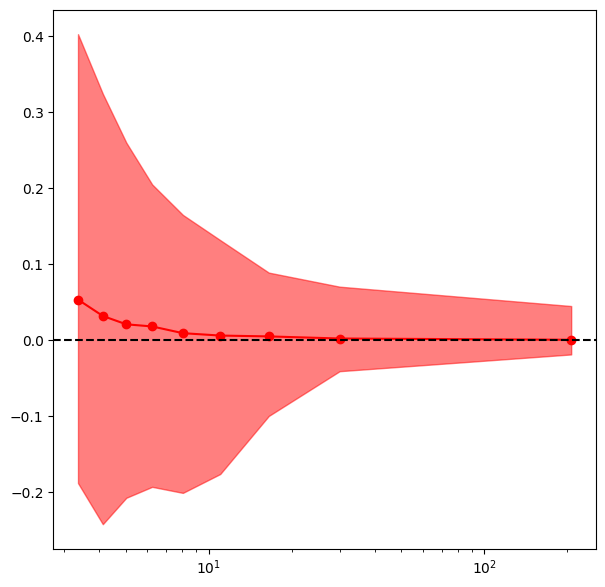

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7,7))
ax.plot(10**snr_middle, m, marker="o", color="r")
ax.fill_between(10**snr_middle, q1, q2, color="r", alpha=0.5)
ax.set_xscale("log")
ax.axhline(0.0, linestyle='--', color='k')


In [ ]:
10**snr_bins

tensor([  3.0005,   3.7685,   4.5401,   5.5764,   6.9925,   9.3156,  13.0384,
         20.9611,  42.5594, 999.8787])

In [ ]:
snr.shape

torch.Size([5702])

In [ ]:
_mask = (_snr > 3.0 ) & (_snr < 3.7685)
_res1 = _res[:, _mask]

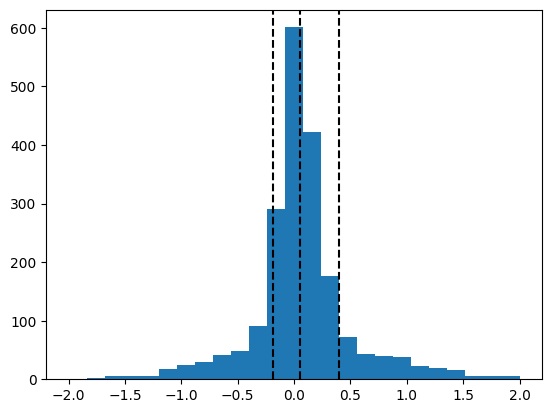

In [ ]:
plt.hist(_res1.ravel(), bins=25, range=(-2, 2))
plt.axvline(_res1.ravel().nanmedian(), linestyle='--', color='k')
plt.axvline(_res1.ravel().nanquantile(0.159), linestyle='--', color='k')
plt.axvline(_res1.ravel().nanquantile(0.841), linestyle='--', color='k')

In [ ]:
bld_mask = (bld > 1e-2) * (bld <= 1)
_bld = bld[bld_mask]
qs = torch.linspace(0, 1, 10)
bld_bins = torch.quantile(_bld, qs)
bld_middle = (bld_bins[1:] + bld_bins[:-1]) / 2


In [ ]:
bld_bins

tensor([0.0100, 0.0196, 0.0331, 0.0552, 0.0892, 0.1471, 0.2390, 0.3826, 0.6311,
        0.9937])

In [ ]:
f1 = rearrange(tflux, 'n -> 1 n')
res = (sfluxes - f1) / f1
_res = res[:, bld_mask]
_res.shape, res.shape

(torch.Size([10, 4792]), torch.Size([10, 5702]))

In [ ]:
m, q1, q2 = _calculate_statistics(_res, _bld, bld_bins)

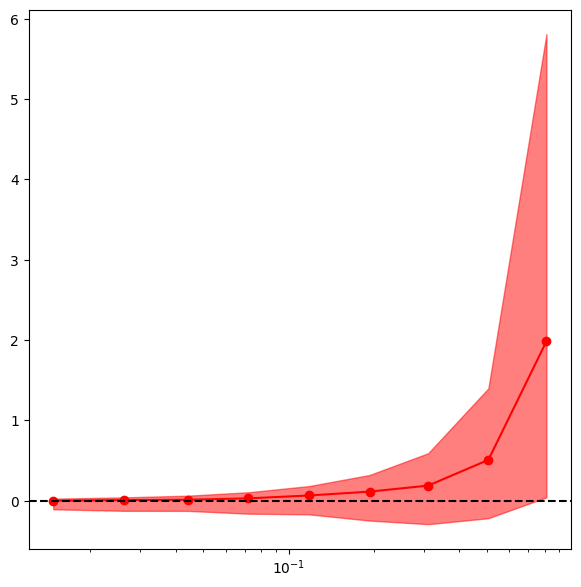

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7,7))
ax.plot(bld_middle, m, marker="o", color="r")
ax.fill_between(bld_middle, q1, q2, color="r", alpha=0.5)
ax.set_xscale("log")
ax.axhline(0.0, linestyle='--', color='k')


## Sizes

In [ ]:
mask = (ds['snr'][:, 0] > 0) & (ds['truth']['galaxy_bools'][:, 0].bool())

tsize = ds['truth']['sigma'][mask, 0]
ssizes = ds['samples']['sigma'][:, mask, 0]
tflux.shape, sfluxes.shape
snr = ds['snr'][mask, 0]

snr.shape, tsize.shape, ssizes.shape

(torch.Size([5702]), torch.Size([5702]), torch.Size([10, 5702]))

In [ ]:
snr_mask = (snr > 3) * (snr <= 1000)
_snr = snr[snr_mask]
_snr_log = torch.log10(_snr)
qs = torch.linspace(0, 1, 10)
snr_bins = torch.quantile(_snr_log, qs)
snr_middle = (snr_bins[1:] + snr_bins[:-1]) / 2

In [ ]:
s1 = rearrange(tsize, 'n -> 1 n')
res = (ssizes - s1) / s1
_res = res[:, snr_mask]
_res.shape, res.shape

(torch.Size([10, 4863]), torch.Size([10, 5702]))

In [ ]:
m, q1, q2 = _calculate_statistics(_res, _snr_log, snr_bins)

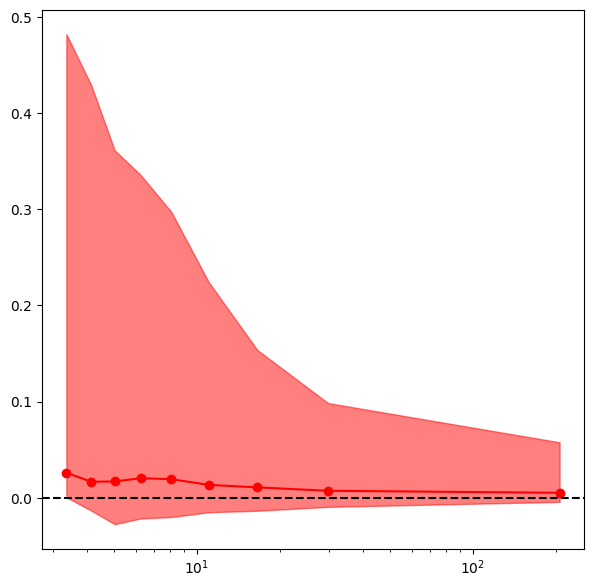

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7,7))
ax.plot(10**snr_middle, m, marker="o", color="r")
ax.fill_between(10**snr_middle, q1, q2, color="r", alpha=0.5)
ax.set_xscale("log")
ax.axhline(0.0, linestyle='--', color='k')


In [ ]:
bld_mask = (bld > 1e-2) * (bld <= 1)
_bld = bld[bld_mask]
qs = torch.linspace(0, 1, 10)
bld_bins = torch.quantile(_bld, qs)
bld_middle = (bld_bins[1:] + bld_bins[:-1]) / 2


In [ ]:
bld_bins

tensor([0.0100, 0.0196, 0.0331, 0.0552, 0.0892, 0.1471, 0.2390, 0.3826, 0.6311,
        0.9937])

In [ ]:
s1 = rearrange(tsize, 'n -> 1 n')
res = (ssizes - s1) / s1
_res = res[:, bld_mask]
_res.shape, res.shape

(torch.Size([10, 4792]), torch.Size([10, 5702]))

In [ ]:
m, q1, q2 = _calculate_statistics(_res, _bld, bld_bins)

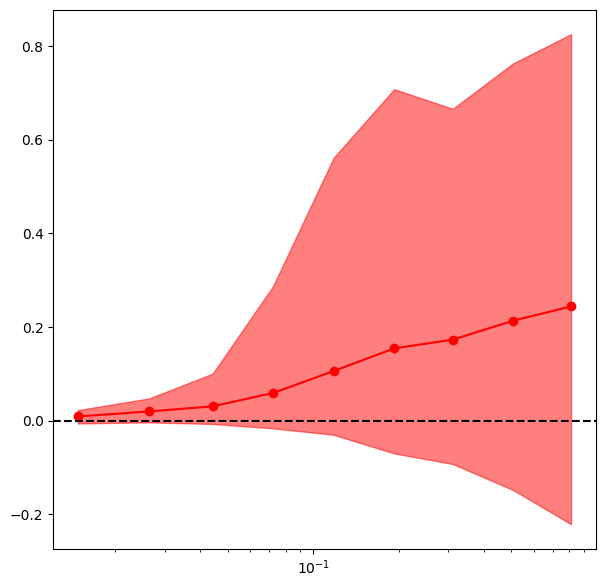

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7,7))
ax.plot(bld_middle, m, marker="o", color="r")
ax.fill_between(bld_middle, q1, q2, color="r", alpha=0.5)
ax.set_xscale("log")
ax.axhline(0.0, linestyle='--', color='k')


## Ellipticity

In [ ]:
ds['truth']['ellips'].shape

torch.Size([6258, 2])

In [ ]:
mask = (ds['snr'][:, 0] > 0) & (ds['truth']['galaxy_bools'][:, 0].bool())

te1 = ds['truth']['ellips'][mask, 0]
se1 = ds['samples']['ellips'][:, mask, 0]
snr = ds['snr'][mask, 0]

snr.shape, te1.shape, se1.shape

(torch.Size([5702]), torch.Size([5702]), torch.Size([10, 5702]))

In [ ]:
snr_mask = (snr > 3) * (snr <= 1000)
_snr = snr[snr_mask]
_snr_log = torch.log10(_snr)
qs = torch.linspace(0, 1, 10)
snr_bins = torch.quantile(_snr_log, qs)
snr_middle = (snr_bins[1:] + snr_bins[:-1]) / 2

In [ ]:
e1 = rearrange(te1, 'n -> 1 n')
res = se1 - e1
_res = res[:, snr_mask]
_res.shape, res.shape

(torch.Size([10, 4863]), torch.Size([10, 5702]))

In [ ]:
m, q1, q2 = _calculate_statistics(_res, _snr_log, snr_bins)

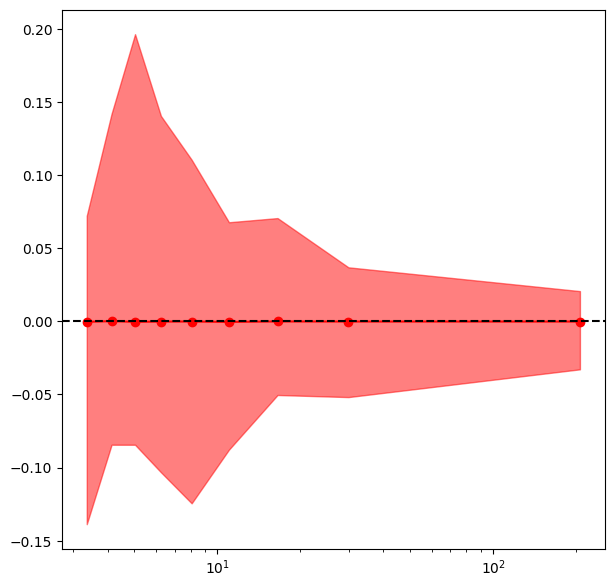

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7,7))
ax.plot(10**snr_middle, m, marker="o", color="r")
ax.fill_between(10**snr_middle, q1, q2, color="r", alpha=0.5)
ax.set_xscale("log")
ax.axhline(0.0, linestyle='--', color='k')


In [ ]:
bld_mask = (bld > 1e-2) * (bld <= 1)
_bld = bld[bld_mask]
qs = torch.linspace(0, 1, 10)
bld_bins = torch.quantile(_bld, qs)
bld_middle = (bld_bins[1:] + bld_bins[:-1]) / 2


In [ ]:
e1 = rearrange(te1, 'n -> 1 n')
res = se1 - e1
_res = res[:, bld_mask]
_res.shape, res.shape

(torch.Size([10, 4792]), torch.Size([10, 5702]))

In [ ]:
m, q1, q2 = _calculate_statistics(_res, _bld, bld_bins)

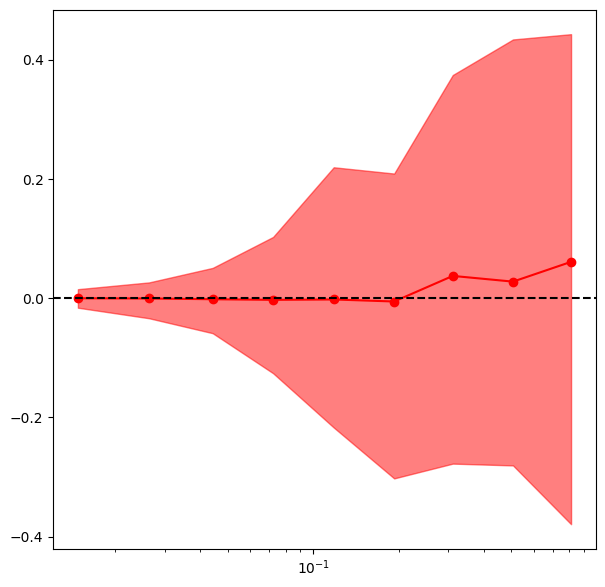

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7,7))
ax.plot(bld_middle, m, marker="o", color="r")
ax.fill_between(bld_middle, q1, q2, color="r", alpha=0.5)
ax.set_xscale("log")
ax.axhline(0.0, linestyle='--', color='k')
